In [1]:
import pickle
with open("noniid_train.txt", "rb") as fp:
    (train_x, train_y) = pickle.load(fp)
with open("noniid_test.txt", "rb") as fp:
    (test_x, test_y) = pickle.load(fp)

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

In [3]:
class PVRDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, z):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.tensor(X, dtype = torch.float)/255
        self.y = torch.tensor(y, dtype = torch.long)
        self.z = torch.tensor(z, dtype = torch.float)/255
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.z[idx]

In [4]:
def proc_dataset(dataset):
    n = len(dataset)
    split_data = np.zeros( (n,4,28,28) )
    for ii in range(len(dataset)):
        for i in range(2):
            for j in range(2):
                split_data[ii,i*2+j,:,:] = dataset[ii][0, 28*i:28*(i+1), 28*j:28*(j+1)]
    return split_data

In [5]:
train_z = proc_dataset(train_x)
test_z = proc_dataset(test_x)

In [6]:
trainset = PVRDataset(train_x, train_y, train_z)
testset = PVRDataset(test_x, test_y, test_z)

In [7]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(testset, batch_size=64, shuffle=False,num_workers=1)

In [15]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 8, 3, 1)

        self.fc1 = nn.Linear(1352, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output
actor = Actor()

In [16]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 8, 3, 1)

        self.fc1 = nn.Linear(1152, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
critic = Critic()

In [17]:
def train(gen, dis, train_loader, optimizer, epoch):
    gen.train()
    dis.train()
    running_loss = 0.0
    correct = 0.0
    
    n = len(train_loader.dataset)
    for batch_idx, (data, target, masks) in enumerate(train_loader):
        optimizer.zero_grad()
        mask_val = gen(data)
        mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
        data_mask = mask_val * masks
        data = torch.sum(data_mask, dim = 1, keepdim = True)
        
        output = dis(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    print('Loss/train:', running_loss/n, 'Accuracy/train:', correct/n)
    return correct/n

In [18]:
def test(gen, dis, test_loader, epoch):
    gen.eval()
    dis.eval()
    test_loss = 0
    correct = 0
    n = len(test_loader.dataset)
    with torch.no_grad():
        for data, target, masks in test_loader:
            mask_val = gen(data)
            mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
            data_mask = mask_val * masks
            data = torch.sum(data_mask, dim = 1, keepdim = True)

            output = dis(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    print('Loss/test:', test_loss/n, 'Accuracy/test:', correct/n)
    return correct/n

In [19]:
acc_train = []
acc_test = []
optimizer = optim.Adam(list(actor.parameters())+list(critic.parameters()), lr=1e-3)
for epoch in range(1, 30):
    acc_train.append(train(actor, critic, train_loader, optimizer, epoch))
    acc_test.append(test(actor, critic, test_loader, epoch))

Loss/train: 0.024830324971675873 Accuracy/train: 0.4644
Loss/test: 1.1090967216491698 Accuracy/test: 0.68
Loss/train: 0.010909339773654938 Accuracy/train: 0.7994
Loss/test: 0.83703098487854 Accuracy/test: 0.776
Loss/train: 0.007351284332573414 Accuracy/train: 0.8736
Loss/test: 0.6018346538543701 Accuracy/test: 0.838
Loss/train: 0.005555172381550073 Accuracy/train: 0.9067
Loss/test: 0.5655652256011963 Accuracy/test: 0.849
Loss/train: 0.004748760039359331 Accuracy/train: 0.9199
Loss/test: 0.5263154373168946 Accuracy/test: 0.864
Loss/train: 0.0036041561756283043 Accuracy/train: 0.9408
Loss/test: 0.5215872650146485 Accuracy/test: 0.86
Loss/train: 0.0027633575987070797 Accuracy/train: 0.9535
Loss/test: 0.5594161281585693 Accuracy/test: 0.874
Loss/train: 0.002078404501825571 Accuracy/train: 0.9642
Loss/test: 0.5674606494903565 Accuracy/test: 0.865
Loss/train: 0.001720302524138242 Accuracy/train: 0.9694
Loss/test: 0.6192642002105713 Accuracy/test: 0.878
Loss/train: 0.0012387856094166637 Accur

In [20]:
def gen_mask():
    masks = []
    m = torch.ones(28,28)
    for x in range(2):
        for y in range(2):
            mask = torch.zeros(1,56,56)
            mask[0, x*28:(x+1)*28, y*28:(y+1)*28] = m
            masks.append(mask)
    return torch.cat(masks).unsqueeze(0)
masks = gen_mask()

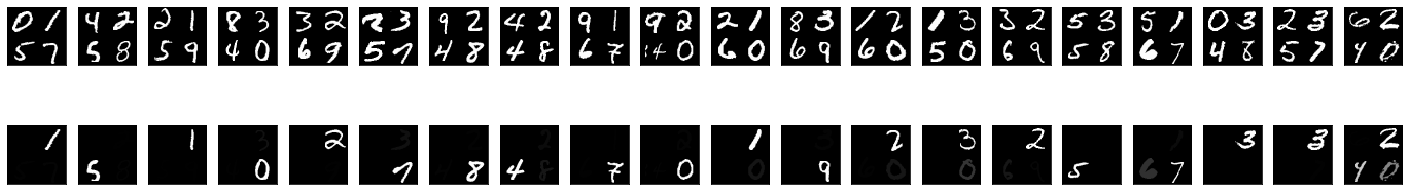

In [22]:
dataiter = iter(test_loader)
images, labels, _ = dataiter.next()

mask_val = actor(images)
mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
data_mask = mask_val * masks.repeat(64,1,1,1)
data = torch.sum(images * data_mask, dim = 1, keepdim = True)
images = images.numpy()
masked_images = data.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=20, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, masked_images], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)